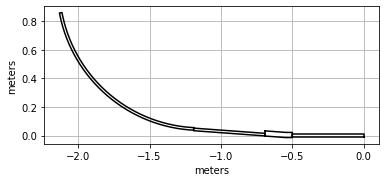

In [1]:
import multiprocess as mp
import numpy as np
from SwarmTracerClass import SwarmTracer
from ParticleTracerLatticeClass import ParticleTracerLattice
from ParticleClass import Particle,Swarm
from elementPT import Drift,HalbachBenderSimSegmented,CombinerHalbachLensSim,HalbachLensSim
import os
from ParticleTracerClass import ParticleTracer



In [2]:
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

particle=pt.trace(particle,1e-5,.01,fastMode=False,accelerated=True)

<elementPT.HalbachLensSim object at 0x10758fdf0> <elementPT.CombinerHalbachLensSim object at 0x107589460>
[ 5.01897401e-01 -3.10031217e-05 -1.32460386e-06] [ 2.09998879e+02 -3.49747629e-01 -3.53129062e-03] [0 0 0] [-0.69159871  0.01460963  0.        ] [[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]] [[ 0.99734535 -0.07281659]
 [ 0.07281659  0.99734535]]
<elementPT.CombinerHalbachLensSim object at 0x107589460> <elementPT.HalbachLensSim object at 0x112ec4790>
[-3.96558568e-04 -8.42284173e-03 -5.38769885e-06] [-2.09993708e+02 -1.22379282e+00 -4.80375385e-03] [-0.69159871  0.01460963  0.        ] [-0.69218659  0.00655763  0.        ] [[ 0.99734535  0.07281659]
 [-0.07281659  0.99734535]] [[-0.99734535  0.07281659]
 [-0.07281659 -0.99734535]]
<elementPT.HalbachLensSim object at 0x112ec4790> <elementPT.HalbachBenderSimSegmented object at 0x28323b9d0>
[ 5.00168570e-01  2.25896699e-04 -1.26088734e-06] [ 2.09991980e+02 -1.55191067e+00  1.64688834e-02] [-0.69218659  0.00655763 

In [107]:
import warnings
import itertools
from math import sqrt,isclose
from typing import Optional,Union
import pandas as pd
from scipy.spatial.transform import Rotation as Rot
from shapely.geometry import Polygon
import numpy as np
import fastNumbaMethodsAndClass
from helperTools import arr_Product,iscloseAll,make_Odd
from HalbachLensClass import HalbachLens as _HalbachLensFieldGenerator
from HalbachLensClass import SegmentedBenderHalbach as _HalbachBenderFieldGenerator
from constants import SIMULATION_MAGNETON
import matplotlib.pyplot as plt
import scipy.optimize as spo
import time




LSep=1e-3
Lm=.0254
Lseg=Lm+LSep
rp=.01
yokeWidth=3e-3
rb=1.02
v0=210
m=1

ucAngTemp=np.arctan(Lseg/(2*(rb-rp-yokeWidth))) #value very near final value, good
#approximation

lens = _HalbachBenderFieldGenerator(rp, rb, ucAngTemp,Lm, numLenses=5,applyMethodOfMoments=True)

thetaArr=np.linspace(-ucAngTemp,ucAngTemp,100)
yArr=np.zeros(len(thetaArr))
def offset_Error(rOffset):
    if rOffset>rp:
        return np.nan
    xArr=(rb+rOffset)*np.cos(thetaArr)
    zArr=(rb+rOffset)*np.sin(thetaArr)
    coords=np.column_stack((xArr,yArr,zArr))
    F=lens.BNorm_Gradient(coords)*SIMULATION_MAGNETON
    Fr=np.linalg.norm(F[:,[0,2]],axis=1)
    FrMean=np.mean(Fr)
    FCen=m*v0**2/(rb+rOffset)
    return (FCen-FrMean)**2
#
# rOffsetArr=np.linspace(0.0,rp*.9,100)
# vals=[offset_Error(rOffset) for rOffset in rOffsetArr]
# plt.scatter(rOffsetArr,vals)
# plt.show()
# np.min(vals)
bounds=[(0.0,rp*.9)]
t=time.time()
sol=spo.minimize(offset_Error,(rp/2.0),bounds=bounds,method='Nelder-Mead',options={'xatol':1e-6}) #1.8372087865209717e-09 array([0.00388324])
print(time.time()-t)
rOffset=sol.x[0]
sol.fun,rOffset #(9.321391417934391e-05, 0.0038778991699218723)

2.7406909465789795


(2.3944991005108755e-05, 0.0038008546829223604)

(0.027, 0.027)

In [73]:
func=lambda x:offset_Error(x[0])
bounds=[(0.0,rp*.9)]
spo.minimize(offset_Error,(rp/2.0),bounds=bounds,method='Nelder-Mead',options={'fatol':1e-9})

 final_simplex: (array([[0.00388324],
       [0.00388324]]), array([1.83720879e-09, 1.95409364e-09]))
           fun: 1.8372087865209717e-09
       message: 'Optimization terminated successfully.'
          nfev: 58
           nit: 29
        status: 0
       success: True
             x: array([0.00388324])

In [2]:
# PTL = ParticleTracerLattice(200.0, latticeType='storageRing')
#
# PTL.add_Halbach_Lens_Sim(.01, .5)
# PTL.add_Drift(.1)
# PTL.add_Combiner_Sim_Lens(.1, .02)
# PTL.add_Halbach_Lens_Sim(.01, .5)
# PTL.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, None, 1, 0.0, rOffsetFact=1.)
# PTL.add_Halbach_Lens_Sim(.01, 1., constrain=True)
# PTL.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, None, 1, 0.0, rOffsetFact=1.)
# PTL.end_Lattice(enforceClosedLattice=False, constrain=True,surpressWarning=True)

0.0033091928597257514
0.0033091928597257514


In [27]:
def get_Error(fact):
    PTL = ParticleTracerLattice(200.0, latticeType='storageRing')


    PTL.add_Drift(.1)
    PTL.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, 300, 1, 0.0, rOffsetFact=fact)
    PTL.end_Lattice(enforceClosedLattice=False, constrain=False,surpressWarning=True)

    from ParticleTracerClass import ParticleTracer
    from ParticleClass import Particle
    pt=ParticleTracer(PTL)
    particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

    particle=pt.trace(particle,1e-5,.01,fastMode=False,accelerated=False)
    PTL.show_Lattice(particle=particle,showTraceLines=True,trueAspectRatio=False)
    particle.plot_Orbit_Reference_Frame_Position()
    particle.plot_Energies(showOnlyTotalEnergy=True)
    error=np.std([q[1] for q in particle.qoArr])
    return error #0.0003401014791188453
# offsetList=list(np.linspace(.95,1.1,10))
# errors=[get_Error(offset) for offset in offsetList]

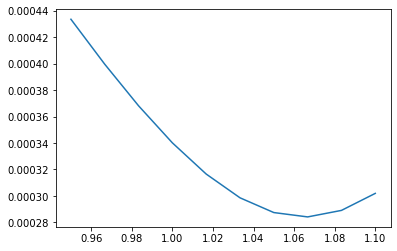

In [10]:
import matplotlib.pyplot as plt
plt.plot(offsetList,errors)
plt.show()

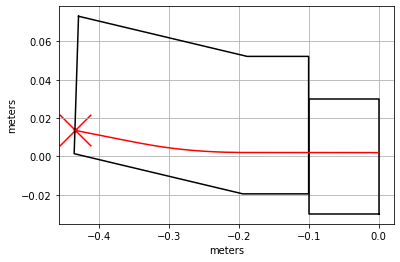

In [3]:

PTL = ParticleTracerLattice(200.0, latticeType='storageRing')
PTL.add_Drift(.1)
PTL.add_Combiner_Sim_Lens(.15,.04)
# PTL.add_Halbach_Lens_Sim(.02,.1,.9)
# PTL.add_Drift(.1)
# PTL.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, 300, 1, 0.0)
PTL.end_Lattice(enforceClosedLattice=False, constrain=False,surpressWarning=True)
from ParticleTracerClass import ParticleTracer
from ParticleClass import Particle
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,2e-3,0.0]))
particle=pt.trace(particle,1e-5,.01,fastMode=False,accelerated=False)
%matplotlib inline
PTL.show_Lattice(particle=particle,showTraceLines=True,trueAspectRatio=False)



In [11]:
PTL.elList[1].force(np.array([.1,0,0]))
PTL.elList[1].r2

array([-0.43232714,  0.01460963,  0.        ])

In [12]:
[q[1] for q in particle.qoArr]

[0.0001,
 0.00010000000000000026,
 0.00010000000000000052,
 0.00010000000000000078,
 0.00010000000000000103,
 0.00010000000000000129,
 0.00010000000000000155,
 0.00010000000000000181,
 0.00010000000000000206,
 0.00010000000000000232,
 0.00010000000000000258,
 0.00010000000000000284,
 0.0001000000000000031,
 0.00010000000000000335,
 0.00010000000000000361,
 0.00010000000000000387,
 0.00010000000000000412,
 0.00010000000000000438,
 0.00010000000000000464,
 0.0001000000000000049,
 0.00010000000000000515,
 0.00010000000000000541,
 0.00010000000000000567,
 0.00010000000000000593,
 0.00010000000000000618,
 0.00010000000000000644,
 0.0001000000000000067,
 0.00010000000000000696,
 0.00010000000000000721,
 0.00010000000000000747,
 0.00010000000000000773,
 0.00010000000000000799,
 0.00010000000000000824,
 0.0001000000000000085,
 0.00010000000000000876,
 0.00010000000000000902,
 0.00010000000000000927,
 0.00010000000000000953,
 0.00010000000000000979,
 0.00010000000000001005,
 0.00010000000000001

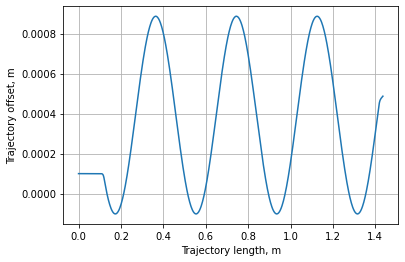

In [8]:
particle.plot_Orbit_Reference_Frame_Position()

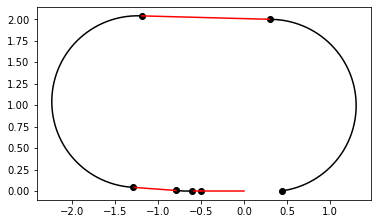

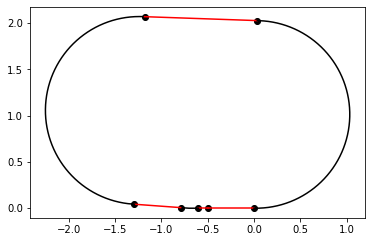

(1.0138167320703577, 244, 1.0127834990172122, 244, 1.2177085041236735)

In [11]:
%matplotlib inline
from storageRingGeometries import Line,Kink,CappedSlicedBend
from storageRingGeometry import StorageRingGeometry
from storageRingGeometrySolver import StorageRingConstraintSolver
firstEl=Line(.5)
firstEl.place(np.array([0.0,0.0]),-np.pi)
Lcap=0.02135#PTL_True.bender1.Lcap



elements=[
    firstEl,
    Line(.1),
    Kink(-0.07288109082330438,L2,L1),
    Line(.5),
    CappedSlicedBend(.0127,240,magnetDepth,Lcap,1.),
    Line(1.5,constrained=True),
    CappedSlicedBend(.0127,230,magnetDepth,Lcap,1.0042770601252802)
]



storageRing=StorageRingGeometry(elements)
storageRing.build()
storageRing.show_Geometry()
solver=StorageRingConstraintSolver(storageRing,1.0)
params=solver.solve()
solver.update_Ring(params)
storageRing=solver.storageRing
# storageRing=solver.make_Valid_Storage_Ring()
storageRing.show_Geometry()
params

need to include shifting this over for offset effect
[-0.99734535  0.07281659] 3.068711562766489
need to include shifting this over for offset effect
[ 0.99939339 -0.03482606] 6.24835220087051


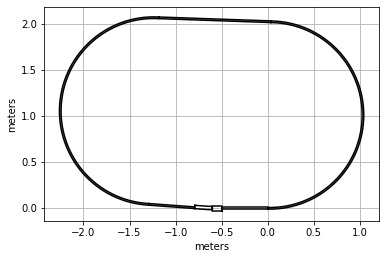

array([ 8.11850587e-16, -4.22669699e-16,  0.00000000e+00])

In [12]:
import matplotlib.pyplot as plt
def build(PTL,storageRing):
    #todo: assert that each element lines up as expected
    for i,elements in enumerate(zip(PTL.elList,storageRing)):
        el_PTL,el_Geom=elements
        if type(el_Geom) is Line:
            el_PTL.r1=np.array([*el_Geom.pos_in,0])
            el_PTL.r2=np.array([*el_Geom.pos_out,0])
            el_PTL.nb=np.array([*el_Geom.n_in,0])
            el_PTL.ne=np.array([*el_Geom.n_out,0])

            theta=np.arctan2(el_Geom.n_out[1],el_Geom.n_out[0])
            if theta<0:
                theta+=np.pi*2
            el_PTL.theta=theta
            el_PTL.ROut = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
            el_PTL.RIn = np.asarray([[np.cos(-theta), -np.sin(-theta)], [np.sin(-theta), np.cos(-theta)]])
        if type(el_Geom) is Kink:

            n_out_perp=-np.flip(el_Geom.n_out)*np.array([-1,1])
            # r2+
            r2=(el_Geom.pos_out+n_out_perp*el_PTL.outputOffset)
            el_PTL.r2=np.array([*r2,0.0])
            el_PTL.r2[1]=0.014609633588606709

            r1=r2+-el_Geom.n_out*el_PTL.Lb+el_Geom.n_in*el_PTL.La
            el_PTL.r1=np.array([*r1,0])

            el_PTL.nb=np.array([*el_Geom.n_in,0])
            el_PTL.ne=np.array([*el_Geom.n_out,0])

            theta=np.arctan2(el_Geom.n_out[1],el_Geom.n_out[0])-np.pi #todo: i think this might be wrong, or not the right way to hink about it

            theta=theta+2*np.pi #conventino
            el_PTL.theta=theta

            rot=el_PTL.theta
            el_PTL.ROut = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
            rot=-rot
            el_PTL.RIn = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])#np.linalg.inv(el_PTL.ROut)
        if type(el_Geom) is CappedSlicedBend:
            print("need to include shifting this over for offset effect")

            el_PTL.r1=np.array([*el_Geom.pos_in,0])
            el_PTL.r2=np.array([*el_Geom.pos_out,0])
            el_PTL.nb=np.array([*el_Geom.n_in,0])
            el_PTL.ne=np.array([*el_Geom.n_out,0])
            el_PTL.r0=np.array([*el_Geom.benderCenter,0])
            # print(el_PTL.r1)
            n=-el_Geom.n_in
            theta=np.arctan2(n[1],n[0])
            if theta<0:
                theta+=np.pi*2
            print(n,theta)
            el_PTL.theta=theta

            rot=el_PTL.theta- el_PTL.ang + np.pi / 2
            el_PTL.ROut = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
            rot=-rot
            el_PTL.RIn = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])#np.linalg.inv(el_PTL.ROut)

build(PTL,storageRing)
# %matplotlib tk
PTL.make_Geometry()
PTL.show_Lattice(trueAspectRatio=True)

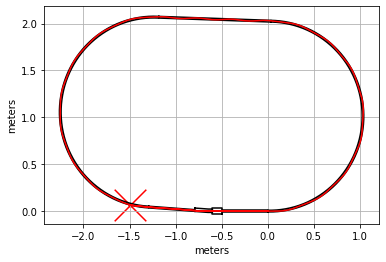

[-1.4989631586306835e+00  6.6685599045931188e-02 -5.4323786337198710e-06]


In [13]:
%matplotlib inline
from ParticleTracerClass import ParticleTracer
from ParticleClass import Particle
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

particle=pt.trace(particle,1e-5,1,fastMode=False,accelerated=False)
PTL.show_Lattice(particle=particle,showTraceLines=True,trueAspectRatio=False)
np.set_printoptions(precision=100)
print(particle.qf) #[-7.3317516263831284e-01  3.4424809584164646e-03 -5.2940775338183833e-06]

In [48]:
particle.plot_Orbit_Reference_Frame_Position()

In [131]:
el=PTL.elList[-1]
q=np.array([.5,.5,0])
# print(el.r1,el.r2)
# print(el.ROut)
# print(el.r2)
# print(el.transform_Element_Coords_Into_Lab_Frame(q))
# print(el.ROut)#@q[:2])#+el.r1[:2])
print(el.ROut)
print(el.RIn)

[[-1.0718754395722282e-15  1.0000000000000000e+00]
 [-1.0000000000000000e+00 -1.0718754395722282e-15]]
[[-1.0718754395722282e-15 -1.0000000000000000e+00]
 [ 1.0000000000000000e+00 -1.0718754395722282e-15]]


In [143]:
PTL_Compare = ParticleTracerLattice(200.0, latticeType='storageRing')


PTL_Compare.add_Halbach_Lens_Sim(.01, .5)
PTL_Compare.add_Combiner_Sim_Lens(.1, .02)
PTL_Compare.add_Halbach_Lens_Sim(.01, .5)
PTL_Compare.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, 251, 1.0419898531028318, 0.0, rOffsetFact=1.)
PTL_Compare.add_Halbach_Lens_Sim(.01, 1.1156855236430039, constrain=True)
PTL_Compare.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, 251, 1.0418702761406033, 0.0, rOffsetFact=1.)
PTL_Compare.end_Lattice(enforceClosedLattice=True, constrain=True,surpressWarning=True)


In [145]:
PTL_Compare.bender1.rb,PTL_Compare.bender2.rb,PTL_Compare.bender1.numMagnets,PTL_Compare.bender2.numMagnets

1.0419898531028318

(1.0419898531028318, 1.0418702761406033, 251, 251)

In [132]:
el=PTL_Compare.elList[-1]
q=np.array([.5,.5,0])
# print(el.r1,el.r2)
# print(el.ROut)
# print(el.r2)
# print(el.transform_Element_Coords_Into_Lab_Frame(q))
# print(el.ROut)#@q[:2])#+el.r1[:2])
print(el.ROut)
print(el.RIn)


[[-8.269460797427576e-16  1.000000000000000e+00]
 [-1.000000000000000e+00 -8.269460797427576e-16]]
[[-8.269460797427576e-16 -1.000000000000000e+00]
 [ 1.000000000000000e+00 -8.269460797427576e-16]]


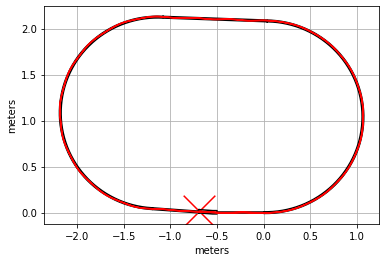

[-6.897707592495245e-01  1.698609428942381e-02 -8.566999319133951e-05]


In [146]:
from ParticleTracerClass import ParticleTracer
from ParticleClass import Particle
pt=ParticleTracer(PTL_Compare)
particle=Particle(qi=np.array([-1e-10,-1e-3,0.0]))

particle=pt.trace(particle,1e-5,1,fastMode=False,accelerated=False)
PTL_Compare.show_Lattice(particle=particle,showTraceLines=True,trueAspectRatio=False)
np.set_printoptions(precision=100)
print(particle.qf) #[-6.287784633004588e-01 -3.911591601543401e-03 -4.206831835417686e-06]

In [44]:
particle.plot_Orbit_Reference_Frame_Position()

In [ ]:
#set first element
PTL.elList[0].r1=storageRing.elements[0].pos_in
PTL.elList[0].r2=storageRing.elements[0].pos_out
n=storageRing.elements[0].n_out
theta=np.arctan2(n[1],n[0])
PTL.elList[0].theta=theta
rot=theta
PTL.elList[0].ROut = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
#rotating out of the element reference frame

In [ ]:
#set combiner
combEl=PTL.elList[1]
combShape=storageRing.elements[1]
n_out_perp=-np.flip(combShape.n_out)*np.array([-1,1])
# r2+
r2=(combShape.pos_out+n_out_perp*combEl.outputOffset)
combEl.r2=np.array([r2[0],r2[1],0.0])

r1=r2+-combShape.n_out*combEl.Lb+combShape.n_in*combEl.La
combEl.r1=np.array([r1[0],r1[1],0])

theta=PTL.elList[0].theta
theta = 2 * np.pi - combEl.ang - (
        np.pi - theta)  # Tilt the combiner down by el.ang so y=0 is perpindicular
# to the input. Rotate it 1 whole revolution, then back it off by the difference. Need to subtract
# np.pi because the combiner's input is not at the origin, but faces 'east'
theta = theta - 2 * np.pi * (theta // (2 * np.pi))  # the above logic can cause the element
# to have to rotate more than 360 deg


combEl.theta=theta

rot=combEl.theta
combEl.ROut = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
#rotating out of the element reference frame
theta,combEl.ang

In [ ]:
PTL.make_Geometry()

In [ ]:
%matplotlib tk
PTL.show_Lattice()

In [ ]:
combEl.ROut

In [ ]:
from SwarmTracerClass import SwarmTracer
st=SwarmTracer(PTL_True)
swarm=st.initalize_PseudoRandom_Swarm_In_Phase_Space(5e-3,5.0,1.0,1000)
swarm=st.trace_Swarm_Through_Lattice(swarm,5e-6,1,fastMode=True)

In [ ]:
from math import isclose
swarm.survival_Rev()
survival=[p.revolutions for p in swarm]
print(max(survival),swarm.survival_Rev())
assert isclose(max(survival),6.07883077933884) and isclose(swarm.survival_Rev(),0.4981934261252685)